# Text Clustering and Topic Modeling

## ArXiv's Articles: Computation and Language

Throughout this chapter, we will be running clustering and topic modeling algorithms on ArXiv articles. 

ArXiv is an open-access platform for scholarly articles, mostly in the fields of computer science, mathematics, and physics.

In [ ]:
# Load the data from Hugginf Face
from datasets import load_dataset
dataset = load_dataset('maartengr/arxiv_nlp')['train']



In [ ]:
# Extract metadata
abstracts = dataset['Abstracts']
titles = dataset['Titles']

## A Common Pipeline for Text Clustering

Although there are many methods for text clustering, from graph-based neural networks to centroid-based clustering techniques, a common pipeline that has gained popularity involves three steps and algorithms:

1. Convert the input documents to embeddings with an embedding model.
2. Reduce the dimensionality of embeddings with a dimensionality reduction model.
3. Find groups of semantically similar documents with a cluster model.

## Embedding Documents


In [ ]:
from sentence_transformers import SentenceTransformer


In [ ]:
# Create an embedding for each abstract
embedding_model = SentenceTransformer("thenlper/gte-small")
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

# Check the dimensions of the resulting embeddings
embeddings.shape

## Reducing the Dimensionality of the Embeddings
Dimensionality reduction allows data in high-dimensional space to be com‐
pressed to a lower-dimensional representation.
Step 2: The embeddings are reduced to a lower-dimensional space using
dimensionality reduction.

Well-known methods for dimensionality reduction are Principal Component Analysis (PCA) and Uniform Manifold Approximation and Projection (UMAP). For this pipeline, we are going with UMAP as it tends to handle nonlinear relationships and structures a bit better than PCA

**Note** : Dimensionality reduction techniques, however, are not flawless.
They do not perfectly capture high-dimensional data in a lower-
dimensional representation. Information will always be lost with
this procedure. There is a balance between reducing dimensionality
and keeping as much information as possible.

In [ ]:
from umap import UMAP

In [ ]:
# We reduce the input embeddings from 384 dimensions to 5 dimensions
umap_model = UMAP(
    n_components = 5,
    min_dist = 0.0,
    metric = 'cosine',
    random_state = 42
)

reduced_embeddings = umap_model.fit_transform(embeddings)

**Note** : Note that setting a random_state in UMAP will make the results reproducible across sessions but will disable parallelism and therefore slow down training.

## Cluster the Reduced Embeddings

Step 3 : We cluster the documents using the embeddings with reduced dimensionality.
The clustering algorithm not only impacts how clusters are generated but also how they are viewed.

Although a common choice is a centroid-based algorithm like k-means, which
requires a set of clusters to be generated, we do not know the number of clusters beforehand. Instead, a density-based algorithm freely calculates the number of clusters and does not force all data points to be part of a cluster.

A common density-based model is Hierarchical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN). HDBSCAN is a hierarchical variation of a clustering algorithm called DBSCAN that allows for dense (micro)-clusters to be found without having to explicitly specify the number of clusters.As a density-based
method, HDBSCAN can also detect outliers in the data, which are data points that do not belong to any cluster. These outliers will not be assigned or forced to belong to any cluster. In other words, they are ignored. Since ArXiv articles might contain some niche papers, using a model that detects outliers could be helpful.

In [ ]:
from hdbscan import HDBSCAN


In [ ]:
# We fit the models and extract the Clusters
hdbscan_model = HDBSCAN(
    min_cluster_size = 50,
    metric = 'euclidean',
    cluster_selection_method = "eom"
).fit(reduced_embeddings)

clusters = hdbscan_model.labels_

# See how many clusters we generated
len(set(clusters))

### Inspecting the Clusters

We can inspect each cluster manually and explore the assigned documents to get an understanding of it's content.

In [ ]:
import numpy as np

In [ ]:
# Print first 3 documents in the cluster 0
cluster = 0
for index in np.where(clusters == cluster)[0][:3]:
    print(abstracts[index][:300] + "....\n")

We can take this one step further and attempt to visualize our results instead of going through all documents manually.

In [ ]:
import pandas as pd


In [ ]:
# Reduce 384-dimensional embeddings to two dimensions for easier visualization
reduced_embeddings = UMAP(
    n_components = 2,
    min_dist = 0.0,
    metric = "cosine",
    random_state = 42
).fit_transform(embeddings)

In [ ]:
# Create dataframe
df = pd.DataFrame(reduced_embeddings, columns = ["x", "y"])
df["titles"] = titles
df["cluster"] = [str(c) for c in clusters]

In [ ]:
# Create a dataframe for cluster (cluster_df) and for the outliers(outliers_df) seperately
clusters_df = df.loc[df.cluster != "-1", : ]
outliers_df = df.loc[df.cluster == "-1", :]

To generate a static plot, we will use the well-known plotting library, matplotlib:

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
# Plot outliers and clusters seperately
plt.scatter(outliers_df.x, outliers_df.y, alpha = 0.05, s = 2, c = "grey")

plt.scatter(
    clusters_df.x, clusters_df.y, c = clusters_df.cluster.astype(int),
    alpha = 0.6, s = 2, cmap = "tab20b"
)
plt.axis("off")

## BERTopic : A Modular Topic Modelling Framework
BERTopic is a topic modeling technique that leverages clusters of semantically similar texts to extract various types of topic representations. The underlying algorithm can be thought of in two steps:
- The first part of BERTopic's pipeline is to create clusters of semantically similar documents.
- The second part of BERTopic’s pipeline is representing the topics: the calculation of the weight of term *x* in a class *c*.

BERTopic uses a class-based variant of term frequency–inverse document frequency (c-TF-IDF) to put more weight on words that are more meaningful to a cluster and put less weight on words that are used across all
clusters.

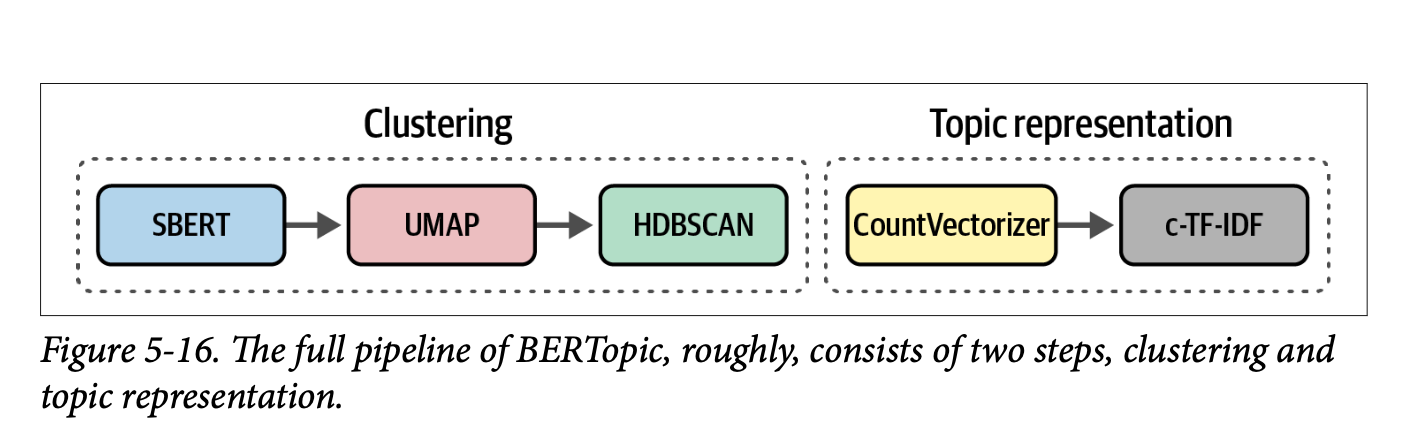

A major advantage of this pipeline is that the two steps, clustering and topic representation, are largely independent of one another.

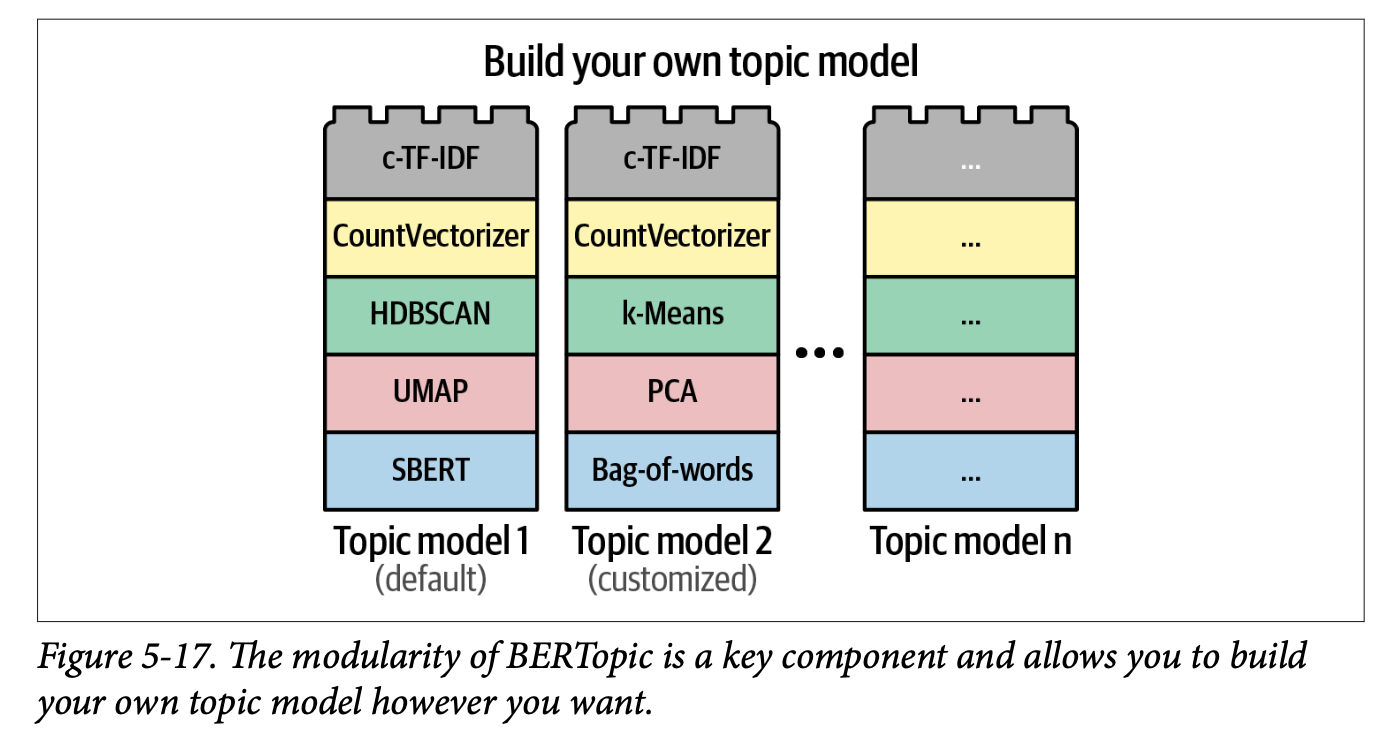

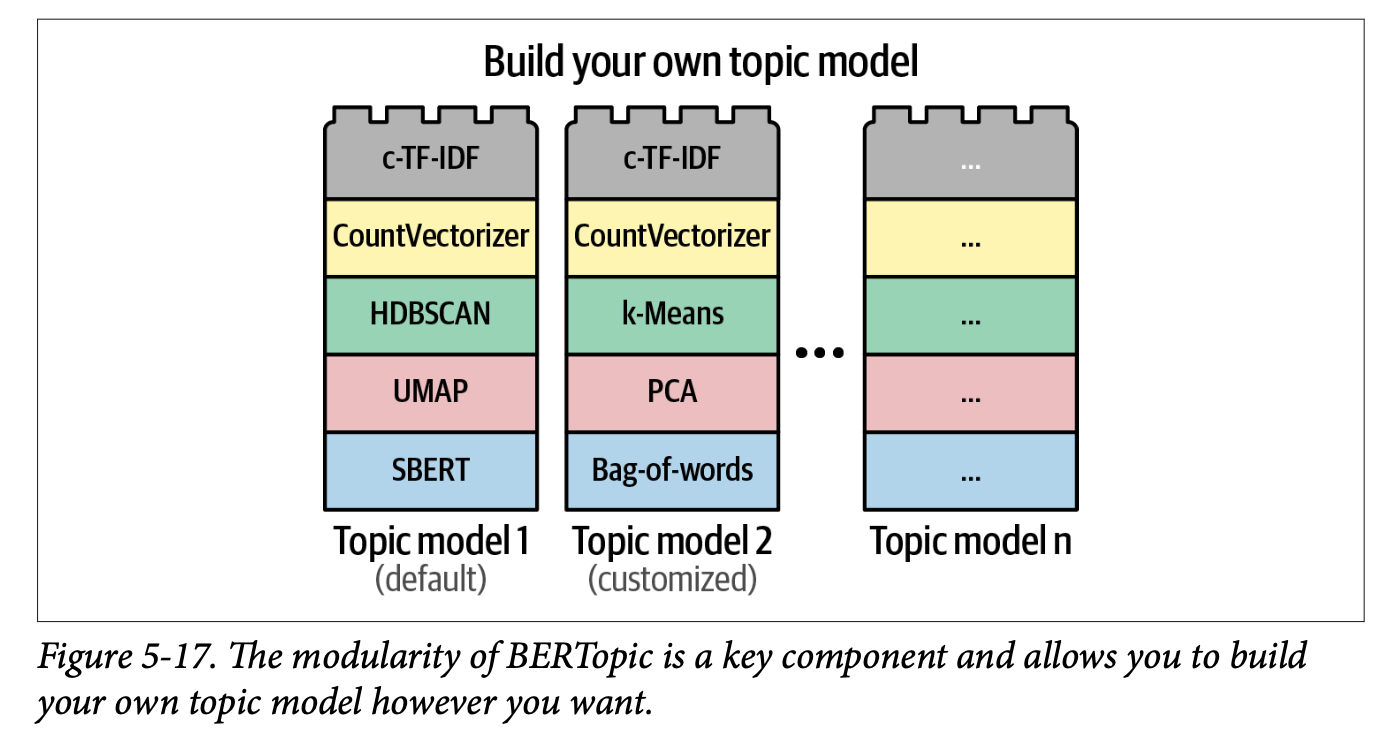

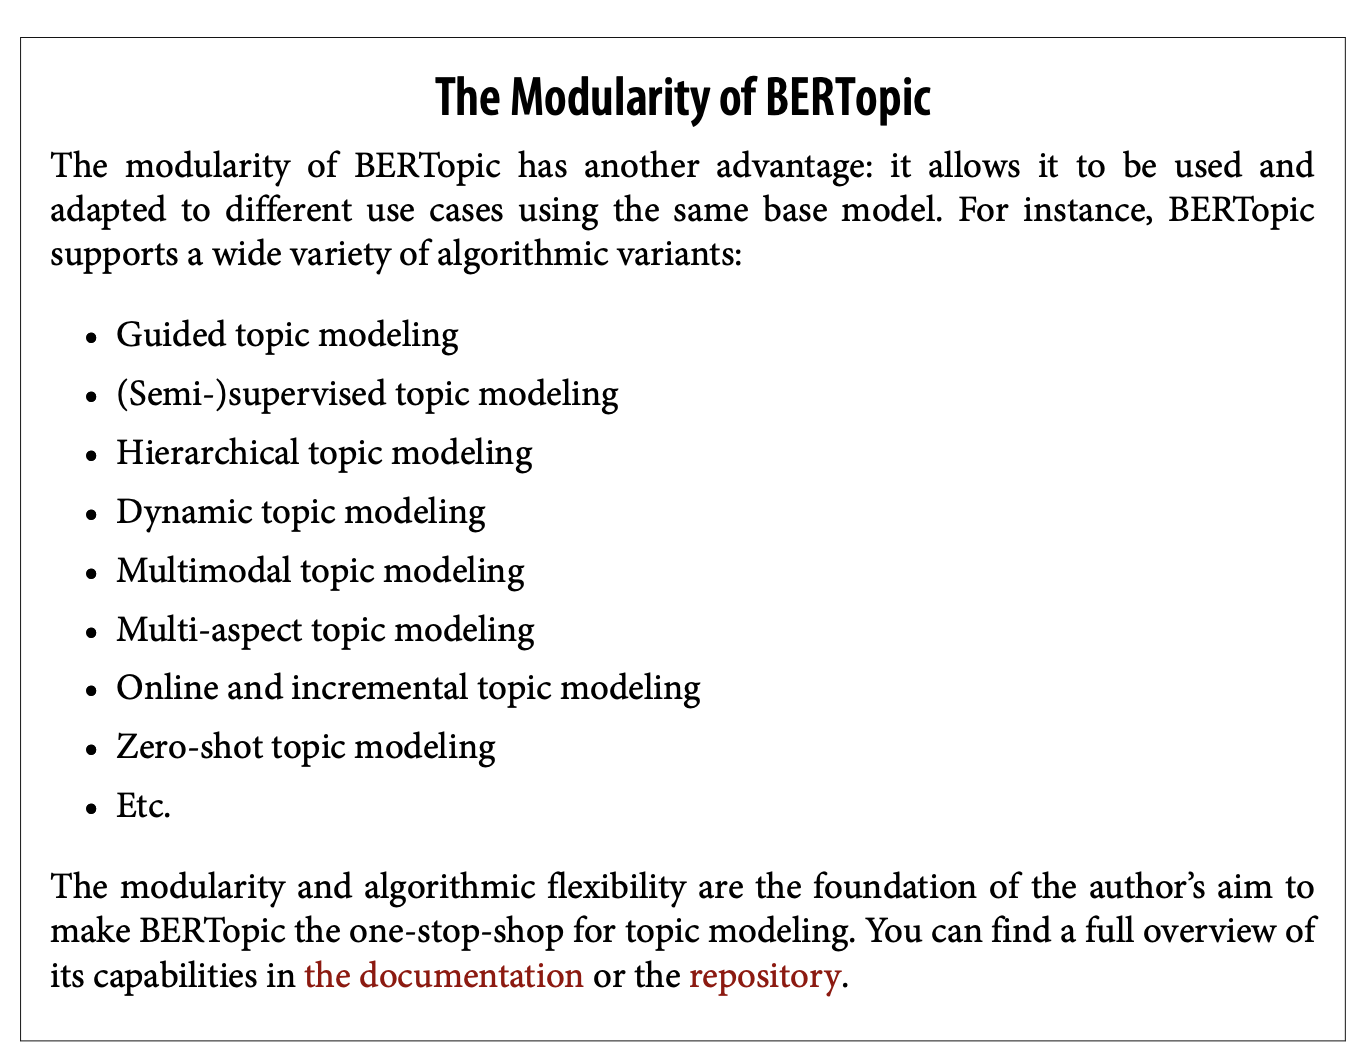



In [ ]:
from bertopic import BERTopic


In [ ]:
# Train our model with our previously defined models
topic_model = BERTopic(
    embedding_model = embedding_model,
    umap_model = umap_model,
    hdbscan_model = hdbscan_model,
    verbose = True
).fit(abstracts, embeddings)

In [ ]:
# Get a quick description of the topic using get_topic_info function
topic_model.get_topic_info()

Each of these topics is represented by several keywords, which are concatenated with a “_” in the Name column.

**Note** : The topic labeled `-1` contains all documents that could not be fitted within a topic and are considered outliers. This is a result of the clustering algorithm, HDBSCAN, which does not force all points to be clustered. To remove outliers, we could either use a non-outlier algo‐
rithm like k-means or use BERTopic’s reduce_outliers() function to reassign the outliers to topics.

In [ ]:
# Inspect individual topics and explore which keywords best represents them with the get_topic function
topic_model.get_topic(1)

In [ ]:
# We can use the find_topics() function to search for specific topics based on a search term.
topic_model.find_topics("topic modelling")

In [ ]:
# Inspect the first topic from the find_topic result
topic_model.get_topic(22)

Although we know that this topic is about topic modeling, let’s see if the BERTopic abstract is also assigned to this topic.

In [ ]:
topic_model.topics_[titles.index("BERTopic: Neural topic modeling with a class-based TF-IDF procedure")]

With BERTopic, we can create an interactive variant that allows us to
quickly explore which topics exist and which documents they contain.

In [ ]:
import nbformat
print(nbformat.__version__)

In [ ]:
import nbformat

# Visualize topics and documents
fig = topic_model.visualize_documents(
    titles,
    reduced_embeddings = reduced_embeddings,
    width = 1200,
    hide_annotations = True
)

# Update the fonts of legend for easier visualizations
fig.update_layout(font=dict(size=16))

In [ ]:
# Visualize barchart with ranked keywords
topic_model.visualize_barchart()

In [ ]:
# Visualize relationships between topics
topic_model.visualize_heatmap(n_clusters = 30)

In [ ]:
# Visualize the potential hierarchical structure of topics
topic_model.visualize_hierarchy()

## Adding a Special Lego Block


In [ ]:
# Save original representations
from copy import deepcopy


In [ ]:
original_topics = deepcopy(topic_model.topic_representations_)

Let's create a short wrapper that we can use to quickly visualize the differences in topic words to compare with and without representation models.


In [ ]:
def topic_differences(model, original_topics, nr_topics = 5):
    """Show the differences in topic representations between two models"""
    df = pd.DataFrame(columns = ["Topic", "Original", "Updated"])
    for topic in range(nr_topics):
        # Extract top 5 words per topic per model
        og_words = " | ".join(list(zip(*original_topics[topic]))[0][:5])
        new_words = " | ".join(list(zip(*model.get_topic(topic)))[0][:5])
        df.loc[len(df)] = [topic, og_words, new_words]

    return df

### KeyBERTInspired

KeyBERT is a method inspired by keyword extraction package. KeyBERT extracts keywords from texts by comparing word and document embeddings through cosine similarity.

In [ ]:
from bertopic.representation import KeyBERTInspired

In [ ]:
# Update our topics representations using KeyBERTInspired
representation_model = KeyBERTInspired()
topic_model.update_topics(abstracts, representation_model = representation_model)

In [ ]:
# Show topic differences
topic_differences(topic_model, original_topics)

### Maximal Marginal Relevance

The algorithm attempts to find a set of keywords that are diverse from one
another but still relate to the documents they are compared to. It does so by embedding a set of candidate keywords and iteratively calculating the next best keyword to add. Doing so requires setting a diversity parameter, which indicates how diverse keywords need to be.

It filters out redundant words and only keep words that contribute something new to topic representation.

In [ ]:
from bertopic.representation import MaximalMarginalRelevance


In [ ]:
representation_model = MaximalMarginalRelevance(0.2)
topic_model.update_topics(abstracts, representation_model = representation_model)

In [ ]:
# Show the topics difference
topic_differences(topic_model, original_topics)

### The Text Generation Lego Block


In [ ]:
from transformers import pipeline
from bertopic.representation import TextGeneration

In [ ]:
prompt = """ I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords : '[KEYWORDS]'.

Based on the documents and keywords, what is this topic about ? """

# Update our topic representations using Flan-T5
generator = pipeline("text2text-generation", model = "google/flan-t5-small", device = "mps:0")

representation_model = TextGeneration(
    generator,
    prompt = prompt,
    doc_length = 50,
    tokenizer = "whitespace"
)
topic_model.update_topics(abstracts, representation_model = representation_model)



In [ ]:
# Show topic differences
topic_differences(topic_model, original_topics)

In [ ]:


# Visualize the topics and documents
fig = topic_model.visualize_document_datamap(
    titles,
    topics = list(range(20)),
    reduced_embeddings = reduced_embeddings,
    width = 1200,
    label_font_size = 11,
    label_wrap_width = 20,
    use_medoids = True,
)

fig.show()